# RL coursework, part IV (30 pts in total)

---

**Name:** Victor Fizesan

**SN:** 20009434

---

**Due date:** *April 10th, 2025*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part4.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

----
**Reminder of copyrights**

Copyrights protect this code/content and distribution or usages of it (or parts of it) without permission is prohibited. This includes uploading it and usage of it in training in any LLMs systems.

### Objectives

#### Q.1: You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.

#### Q.2: You will be looking at other, TD-like, updates to learn the value function. You will be asked to investigate different properties of these: e.g. convergence properties, variance of updates. This is akin to a typical analysis one would undertaken when proposing a new update rule to learn value functions.


## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)

# Fix font issues
plt.rcParams.update({
    'font.family': 'Arial',        
    'mathtext.fontset': 'stix',    
    'text.usetex': False,          
})

## Section A: Multi-step + offpolicy in practice [11 points total]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency.

In [2]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  del pi
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))

  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 1.1 [5 points]
Implement the return functions below and run the cells below that.

In [3]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with full importance-sampling corrections,
  so that G_t is corrected with the full importance-sampling correction
  from t to the end of the trajectory.
  """
  T = len(rewards)
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  rho = np.cumprod((pi / mu)[::-1])[::-1] 
  G = np.zeros((T,))

  for t in reversed(range(T)):
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]
  return (1 - l)*v + l*rho*G



def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with per-decision importance-sampling corrections.
  """
  T = len(rewards)
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  rho = pi / mu
  G = np.zeros((T,))

  for t in reversed(range(T)):
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*rho[t]*G[t + 1])
  v = v[:-1]
  return (1 - l)*v + l*rho*G



def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with
  1. per-decision importance-sampling corrections, and
  2. control variates.
  """
  T = len(rewards)
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  rho = pi / mu
  delta = np.zeros((T,))

  for t in reversed(range(T)):
    td_error = r[t] + d[t]*v[t + 1] - v[t]
    if t < T - 1:
      td_error += d[t]*l*rho[t]*delta[t + 1]
    delta[t] = td_error

  v = v[:-1]
  return v + l*rho*delta



def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with
  1. per-decision IS corrections,
  2. control variates, and
  3. adaptive bootstrapping, where lambda_t = lambda * min(1, 1/rho_t).
  """
  T = len(rewards)
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  rho = pi / mu
  lambda_t = l * np.minimum(1.0, 1.0 / rho)
  delta = np.zeros((T,))

  for t in reversed(range(T)):
    td_error = r[t] + d[t]*v[t + 1] - v[t]
    if t < T - 1:
      td_error += d[t]*lambda_t[t]*rho[t]*delta[t + 1]
    delta[t] = td_error

  v = v[:-1]
  return v + lambda_t*rho*delta

In [4]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...

  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state

  # in this case, observations are just the real states
  observations = states

  # generate rewards
  rewards     = 2.*actions - 1. # -1 for left, +1 for right,
  rewards[-1] = np.sum(actions)  # extra final reward for going right

  # compute discounts
  discounts     = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0

  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities

  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



[ 20.592 438.912 279.784  56.25    2.282]


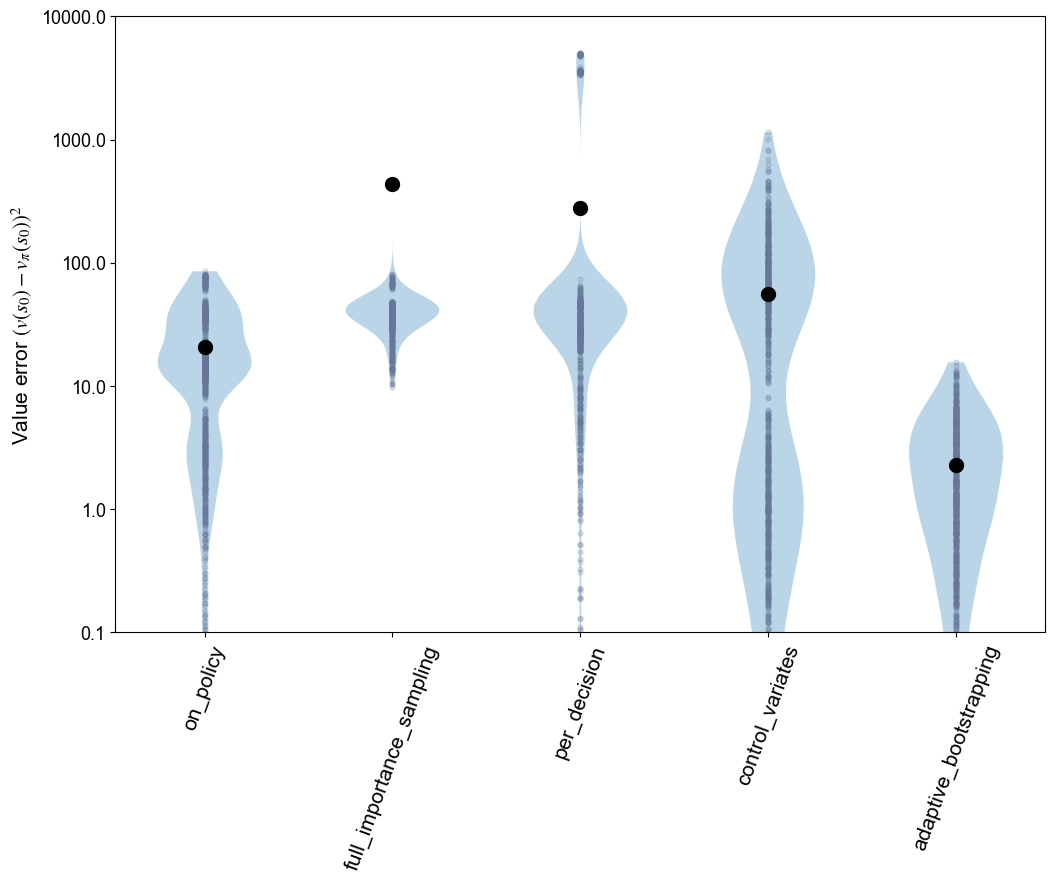

In [5]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision', 'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 1.2 [3 points]
Explain the ranking in terms of value error of the different return estimates.

The ranking reflects a progression in variance reduction and bias-variance tradeoff. Per-decision and full importance sampling perform worst, with errors of 279.78 and 438.91 respectively, due to high variance from off-policy weighting—especially severe in per-decision due to compounding instability. On-policy returns (20.59) avoid this but remain noisy from full trajectory variance. Control variates (56.25) reduce this by incorporating value baselines, improving accuracy. Adaptive bootstrapping (2.28) achieves the lowest error by dynamically adjusting bootstrapped targets, striking an optimal balance between bias and variance. Each method incrementally improves sample efficiency and estimation stability.



### Q 1.3 [3 points]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

Yes—despite its low error, adaptive bootstrapping is not always the best choice when learning off-policy, because its dynamic adjustment of $\lambda_t$ can introduce bias by prematurely truncating returns, especially early in training when value estimates are unreliable. Unlike variance-reduction techniques that preserve unbiasedness (e.g., per-decision importance sampling, which strictly improves over full importance sampling), adaptive methods trade variance for bias, which can harm policy improvement or convergence guarantees. In high-stakes or safety-critical settings, unbiased methods may be preferred despite higher variance. Moreover, methods that rely on learned value functions can be brittle when approximation errors are high, making simpler or unbiased estimators more robust in practice.


## Section B: Potential different algorithms/updates [19 points total]
 Consider a MDP $M = (\mathbb{S}, \mathbb{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:




### Q2.1 [9 points]
Consider a learning update based on the following temporal difference error:
$$\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$$

Consider updating a tabular action value function with TD.

i) Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under fixed behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 points)

ii) Under which conditions, would the above process converge to the optimal value function $q_*$ ? (2 points)

---

i) The resulting value function does converge under any initialization of the Q-function, assuming the Robbins–Monro conditions and infinite interactions under a fixed behavior policy. Below is a proof that two‐step Q‐learning converges in the tabular setting. This follows closely from the 1‐step Q‐learning convergence argument [here](http://users.isr.ist.utl.pt/~mtjspaan/readingGroup/ProofQlearning.pdf).

We define the two-step backup operator $H$ as follows:
$$
(Hq)(s,a) = r(s,a) + \mathbb{E}\left[\gamma R_{t+2} + \gamma^2 \max_{a'} q(S_{t+2}, a') \,\middle|\, S_t = s, A_t = a, \mu \right]
$$
This operator captures the update target used in two-step Q-learning: the immediate reward $r(s,a)$, followed by an action $A_{t+1} \sim \mu$ and then a greedy max over $q(S_{t+2}, \cdot)$. The key idea is to show that this operator $H$ is a contraction in the supremum norm, which ensures the existence of a unique fixed point and convergence under stochastic approximation.

Let $q$ and $u$ be two arbitrary bounded Q-functions. Then:
$$
(Hq)(s,a) - (Hu)(s,a) = \gamma^2 \,\mathbb{E}\left[ \max_{a'} q(S_{t+2}, a') - \max_{a'} u(S_{t+2}, a') \right]
$$
Using standard inequalities:
- $|\mathbb{E}[X]| \le \mathbb{E}[|X|]$
- $|\max_a f(a) - \max_a g(a)| \le \max_a |f(a) - g(a)|$

we obtain:
$$
|(Hq)(s,a) - (Hu)(s,a)| \le \gamma^2 \,\mathbb{E}\left[ \max_{a'} |q(S_{t+2}, a') - u(S_{t+2}, a')| \right] \le \gamma^2 \|q - u\|_\infty
$$
Since this holds for all $(s,a)$, we conclude that:
$$
\|Hq - Hu\|_\infty \le \gamma^2 \|q - u\|_\infty
$$
So $H$ is a $\gamma^2$-contraction on the space of bounded Q-functions. By the Banach Fixed-Point Theorem, there exists a unique fixed point $q_\star$ such that:
$$
q_\star = Hq_\star
$$

We now show that two-step Q-learning converges to this fixed point under stochastic approximation. At each time $t$, the update is of the form:
$$
q(S_t,A_t) \leftarrow q(S_t,A_t) + \alpha_t \left[
r_t + \gamma r_{t+1} + \gamma^2 \max_{a'} q(S_{t+2}, a') - q(S_t,A_t)
\right]
$$
where $\alpha_t$ is a learning rate satisfying the Robbins–Monro conditions:
- $\sum_t \alpha_t = \infty$
- $\sum_t \alpha_t^2 < \infty$

We also assume that the behavior policy $\mu$ induces infinite visitation of all state–action pairs. These conditions guarantee that the two-step update is an unbiased sample of $Hq$ and that each $(s,a)$ is updated infinitely often with diminishing step sizes. Then, by standard stochastic approximation theory (e.g., results from Tsitsiklis & Van Roy or Jaakkola et al.), we conclude that the iterates $q_t$ converge almost surely to the unique fixed point $q_\star$.

**Note**: $q_\star$ is not necessarily the optimal Q-function $q^*$, since the second action is sampled from the behavior policy $\mu$ rather than being chosen greedily. The fixed point corresponds to the solution of a two-step Bellman-like equation involving $\mu$ in the second action.

---

ii) The process converges to the optimal value function $q_*$ if and only if the behavior policy $\mu$ is greedy with respect to $q_*$, i.e.,
$$
\mu(a \mid s) = \mathcal{I}\left(a = \arg\max_{a'} q_*(s, a')\right).
$$
This ensures that the second action in the two-step backup is also optimal, making $q_*$ the fixed point of the two-step operator $H$.

This is because the backup used in $H$ depends on $\mu$ for the second action; only when $\mu$ selects optimal actions does $H$ align with the Bellman optimality operator.

---


### Q2.2 [10 points]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathbb{A} \times \mathbb{S}$ and consider the behaviour policy to be either:

  a. $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathbb{A} \times \mathbb{S}$,
  
  b. $\mu(a|s) = \frac{1}{|\mathbb{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (4 points)
* ii) How does the variance of this update compare to the one induced by the error in Q2.1? (3 points).
* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$ (a and b)? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (3 points)

---
**i)** 

**(a) $\mu(a|s) \in \arg\max_{a} q(s,a)$**  

Here, $\mu$ and $\pi$ coincide; thus, for every state–action pair we actually select,
$$
\frac{\pi(A_{t+1} \mid S_{t+1})}{\mu(A_{t+1} \mid S_{t+1})} = 1.
$$
Because the importance‐sampling ratio is $1$, the two‐step update in the TD error becomes structurally identical to the two‐step method in Q2.1. From Q2.1, we know that if the behavior policy $\mu$ (now identical to $\pi$) visits every state–action pair infinitely often (or meets the same “coverage” conditions stated in Q2.1), the update converges (under Robbins–Monro learning rates) to the unique fixed point of its two‐step backup operator. Since $\mu=\pi$ always acts greedily with respect to $q$, that operator is exactly the Bellman optimality operator in two‐step form, which has $q_*$ as its unique solution. Therefore, under the exploration conditions assumed in Q2.1, this process converges to the optimal value function $q_*$.

**(b) $\mu(a|s) = \frac{1}{|\mathcal{A}|}$**  

Now $\mu$ is uniform over all actions, while $\pi$ remains greedy w.r.t. $q$. Let $s$ be a non‐terminal state and $a'$ any action that is not optimal in $s$. Then $\pi(a' \mid s) = 0$, so
$$
\frac{\pi(a' \mid s)}{\mu(a' \mid s)} = \frac{0}{1/|\mathcal{A}|} = 0.
$$
Hence, whenever $a'$ (suboptimal in $s$) is chosen by the uniform $\mu$, the two‐step target includes a factor of 0 for the future‐looking term. Concretely,
$$
\delta_t = r(s,a') + \gamma \cdot 0 \cdot 
\Bigl[r(S_{t+1},A_{t+1}) + \gamma \max_a q(S_{t+2},a)\Bigr]
- q(s,a').
$$
This simplifies to
$$
\delta_t = r(s,a') - q(s,a').
$$
Since $a'$ is chosen infinitely often under the uniform policy, $q(s,a')$ will repeatedly be pushed toward the immediate reward $r(s,a')$. Thus, in general, these suboptimal actions do not incorporate any “future” return. As a result, the learning process fails to propagate correct future values for non‐greedy actions, leading to a distorted value function that *does not* match the true $q_*$.

In many MDPs, this effectively drives each suboptimal $q(s,a')$ to something close to $r(s,a')$ (plus a small $\gamma$ term if $\pi$ temporarily chooses that action one step later), while the “greedy” action $a^*$ in each state may also be updated in a skewed way. Therefore, there is no guarantee of learning the correct $q_*$. The process typically converges to a solution that overweights immediate rewards or at best considers only two steps in the future for the greedy actions, rather than capturing the optimal infinite‐horizon returns. 

---

**ii)** 

**(a) $\mu(a|s) \in \arg\max_{a} q(s,a)$**  

Again, the variance of this update is the same as in Q2.1. Since there is no stochastic scaling applied to the return, the variance is driven only by the inherent randomness of rewards and transitions.

**(b) $\mu(a|s) = \frac{1}{|\mathcal{A}|}$**  

Since $\pi$ is greedy while $\mu$ samples all actions uniformly, for suboptimal actions $a'$, we have $\pi(a'|s) = 0$ and hence the ratio is zero. The TD error reduces to $\delta_t = r(s,a') - q(s,a')$, which excludes any variance from future rewards, making it lower than in Q2.1. For the optimal action $a^*$, the ratio becomes $|\mathcal{A}|$, amplifying the variance of the future return term by a factor of $|\mathcal{A}|^2$. Although non-greedy actions contribute low variance updates, the amplification in the greedy case dominates overall. Consequently, this update has **higher variance** than Q2.1, especially at the optimal actions, due to the squared scaling of the importance weights.
 

---

**iii)**

One natural alternative is to use an $\epsilon$-greedy policy with respect to $q$. For state $s$,
$$
\mu(a \mid s) \;=\;
\begin{cases}
1 - \epsilon + \dfrac{\epsilon}{|\mathcal{A}|}, & \text{if } a = \arg\max_{a'} q(s,a'), \\
\dfrac{\epsilon}{|\mathcal{A}|}, & \text{otherwise}.
\end{cases}
$$
This ensures that every action is tried infinitely often (so we explore), yet the greedy action is preferred most of the time. Compared to the **uniform** policy (which can have importance‐sampling ratios up to $|\mathcal{A}|$) or a near‐greedy policy with $\mu(a^*\mid s) \approx 0$ (which can blow up the ratio), this $\epsilon$-greedy approach **bounds** the ratio:
$$
\frac{\pi(a^* \mid s)}{\mu(a^* \mid s)} 
\;=\;
\frac{1}{1 - \epsilon + \tfrac{\epsilon}{|\mathcal{A}|}}
\;<\;
|\mathcal{A}|,
$$
and thereby limits variance growth relative to uniform.  

In theory, if we allow $\mu = \pi$ to fully explore – i.e. the greedy policy somehow visits all state–action pairs infinitely often —, then the importance-sampling ratio is always $1$, resulting in minimal possible variance. However, in most MDPs, purely greedy policies fail to explore sufficiently, making $\mu = \pi$ impractical in general. An $\epsilon$-greedy policy offers an effective compromise: it guarantees exploration while keeping the importance-sampling ratio bounded and significantly smaller than in the uniform case. 
